In [2]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [3]:
import survivors.datasets as ds
from survivors.tree import CRAID

param = {'criterion': 'peto', 'cut': True, 'depth': 10,
         'max_features': 1.0, 'min_samples_leaf': 5, 
         'signif': 0.05}

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
param["categ"] = categ

# cr = CRAID(**param)
# cr.fit(X, y)

# pred_cens = cr.predict(X, target="cens")

In [3]:
categ

['trt', 'sex', 'ascites', 'hepato', 'spiders']

In [125]:
# def coxph_negative_gradient(cnp.npy_uint8[:] event,
#                             cnp.npy_double[:] time,
#                             cnp.npy_double[:] y_pred):
#     cdef cnp.npy_double s
#     cdef int i
#     cdef int j
#     cdef cnp.npy_intp n_samples = event.shape[0]

#     cdef cnp.ndarray[cnp.npy_double, ndim=1] gradient = cnp.PyArray_EMPTY(1, &n_samples, cnp.NPY_DOUBLE, 0)
#     cdef cnp.npy_double[:] exp_tsj = cnp.PyArray_ZEROS(1, &n_samples, cnp.NPY_DOUBLE, 0)

#     cdef cnp.npy_double[:] exp_pred = np.exp(y_pred)
#     with nogil:
#         for i in range(n_samples):
#             for j in range(n_samples):
#                 if time[j] >= time[i]:
#                     exp_tsj[i] += exp_pred[j]

#         for i in range(n_samples):
#             s = 0
#             for j in range(n_samples):
#                 if event[j] and time[i] >= time[j]:
#                     s += exp_pred[i] / exp_tsj[j]
#             gradient[i] = event[i] - s

#     return gradient

from numba import njit, jit

@jit  # ('f8(i8[:], f8[:], f8[:])')
def coxph_negative_gradient(event, time, y_pred):
    n_samples = event.shape[0]

    gradient = np.zeros(n_samples, dtype=float)
    exp_tsj = np.zeros(n_samples, dtype=float)

    exp_pred = np.exp(y_pred)
    for i in range(n_samples):
        for j in range(n_samples):
            if time[j] >= time[i]:
                exp_tsj[i] += exp_pred[j]

    for i in range(n_samples):
        s = 0
        for j in range(n_samples):
            if event[j] and time[i] >= time[j]:
                s += exp_pred[i] / exp_tsj[j]
        gradient[i] = event[i] - s

    return gradient

@jit
def fast_coxph_negative_gradient(event, time, y_pred):
    n_samples = event.shape[0]
    r = np.repeat(time[:, np.newaxis], n_samples, axis=1)
    exp_pred = np.exp(y_pred)
    exp_tsj = exp_pred.dot(r >= r.T)

    shared_j = event/exp_tsj
    gradient = event - exp_pred*shared_j.dot(r <= r.T)
    
    return gradient

In [128]:
%timeit coxph_negative_gradient(y["cens"], y["time"], pred_cens)

569 µs ± 4.47 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [129]:
%timeit fast_coxph_negative_gradient(y["cens"], y["time"], pred_cens)

1.98 ms ± 5.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
np.vstack([y["cens"], pred_cens, grad]).T

array([[ 1.        ,  1.        ,  0.85628939],
       [ 0.        ,  0.16470588, -0.93795051],
       [ 1.        ,  0.625     ,  0.73621406],
       ...,
       [ 0.        ,  0.16470588, -0.16909675],
       [ 0.        ,  0.16470588, -0.09234032],
       [ 0.        ,  0.01724138, -0.13255543]])

In [29]:
np.nan * 0

nan

In [ ]:
from sksurv.ensemble import RandomSurvivalForest

In [281]:
import numpy as np
from survivors.metrics import ibs, iauc, ipa, get_survival_func
from survivors.constants import get_y

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

bins = np.array([1, 10, 100, 1000])

y_train = get_y(np.array([1, 0]), np.array([100, 100]))
y_test_1 = get_y(np.array([1]), np.array([100]))
y_test_2 = get_y(np.array([0]), np.array([100]))
y_test_3 = get_y(np.array([1]), np.array([50]))

kmf_train = KaplanMeierFitter()
kmf_train.fit(y_train['time'], event_observed=y_train['cens'])
sf_train = kmf_train.survival_function_at_times(bins).to_numpy()[np.newaxis, :]

In [282]:
ibs(y_train, y_test_3, sf_train, bins)

0.23648648648648649

In [212]:
class KaplanMeier:
    def __init__(self):
        self.timeline = None
        self.survival_function = None
        self.confidence_interval_ = None
        self.alpha = 0.05

    def fit(self, durations, right_censor, weights=None):
        if weights is None:
            weights = np.ones(right_censor.shape)
        self.timeline = np.unique(durations)

        dur_ = np.searchsorted(self.timeline, durations)
        hist_dur = np.bincount(dur_, weights=weights)
        self.hist_cens = np.bincount(dur_, weights=right_censor*weights)
        self.cumul_hist_dur = np.cumsum(hist_dur[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - self.hist_cens / (self.cumul_hist_dur)))])

    def count_confidence_interval(self):
        ''' exponential Greenwood: https://www.math.wustl.edu/~sawyer/handouts/greenwood.pdf '''
        z = ss.norm.ppf(1 - self.alpha / 2)
        cumulative_sq_ = np.sqrt(np.hstack([0.0, np.cumsum(self.hist_cens / (self.cumul_hist_dur * (self.cumul_hist_dur - self.hist_cens)))]))
        np.nan_to_num(cumulative_sq_, copy=False, nan=0)
        v = np.log(self.survival_function)
        np.nan_to_num(v, copy=False, nan=0)
        self.confidence_interval_ = np.vstack([np.exp(v * np.exp(- z * cumulative_sq_ / v)),
                                               np.exp(v * np.exp(+ z * cumulative_sq_ / v))]).T
        np.nan_to_num(self.confidence_interval_, copy=False, nan=1)

    def get_confidence_interval_(self):
        if self.confidence_interval_ is None:
            self.count_confidence_interval()
        return self.confidence_interval_

    def survival_function_at_times(self, times):
        place_bin = np.digitize(times, self.timeline)
        return self.survival_function[np.clip(place_bin, 0, None)]

In [348]:
# @jit()
# def _brier_score(ti, t, s, g_t, g_ti, d):
#     if (ti <= t) and d == 1:
#         return np.power(s, 2) * 1./g_ti
#     if ti > t:
#         return np.power(1 - s, 2) * 1./g_t
#     return 0.

@jit()
def _brier_score(ti, t, s, g_t, g_ti, d):
    return np.where(ti > t, 
                    np.power(1 - s, 2) * 1./g_t, 
                    np.where(d == 1, 
                             np.power(s, 2) * 1./g_ti, 
                             0.0))

def _inverse_censoring_metric(func):
    def metric(survival_train, survival_test, estimate, times):
        ipcw = KaplanMeier()
        ipcw.fit(survival_train["time"], 1 - survival_train["cens"])
        g_t = ipcw.survival_function_at_times(times)
        g_ti = ipcw.survival_function_at_times(survival_test["time"])
        arr = np.zeros_like(estimate, dtype=float)
        
        for i, t in enumerate(times):
            arr[:,i] = func(survival_test["time"], t, estimate[:,i], g_t[i], g_ti, survival_test["cens"])
        return arr
    return metric

def _integrated_metric(func):
    def metric(survival_train, survival_test, estimate, times):
        scores = func(survival_train, survival_test, estimate, times)
        integral = np.trapz(scores, times)
        return integral / (times[-1] - times[0])
    return metric

In [349]:
ibs__ = _inverse_censoring_metric(_brier_score)

In [350]:
ibs_ = _integrated_metric(ibs__)

In [287]:
ibs_(y_train, y_test_3, sf_train, bins)

[[0.   0.   0.25 0.25]]


array([0.23648649])

In [312]:
from survivors.experiments.grid import generate_sample

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
gen = generate_sample(X, y, 5)
X_train, y_train, X_test, y_test, bins = next(gen)

cr = CRAID(**param)
cr.fit(X_train, y_train)

pred_sf = cr.predict_at_times(X_test, bins, mode="surv")

In [356]:
pred_hf = cr.predict_at_times(X_test, bins, mode="hazard")

In [353]:
%timeit ibs_(y_train, y_test, pred_sf, bins)

22.1 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [354]:
%timeit ibs(y_train, y_test, pred_sf, bins, axis=0)

31 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [355]:
def loglikelihood(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    likelihood = np.sum(np.log(sf_by_times) + np.log(hf_by_times))
    return likelihood

def kl(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    likelihood = np.sum(np.log(sf_by_times) + np.log(hf_by_times))
    return likelihood

In [357]:
loglikelihood(y_test["time"], y_test["cens"], pred_sf, pred_hf, bins)

-1099.563431516333

In [360]:
y_test["time"], bins
np.bincount(index_times)

array([ 0,  0,  0, ...,  0,  1, 12], dtype=int64)

In [390]:
# Kullback–Leibler divergence

index_times = np.digitize(y_test["time"], bins, right=True) - 1
arr = np.zeros_like(pred_hf, dtype=int)
arr[np.arange(arr.shape[0]), index_times] = 1
hf = np.hstack((pred_hf[:, 0][np.newaxis].T, np.diff(pred_hf)))

np.sum(hf * np.log((hf + 1e-20)/(arr + 1e-20)), axis=1)

array([103.07480247,  87.3916971 ,  36.01652794, 108.36656156,
        86.50062991,   0.        ,   5.05844785,  87.3916971 ,
        86.50062991,  86.50062991,  36.01652794, 103.07480247,
         0.        , 111.14680412,  87.3916971 ,   0.        ,
        86.50062991, 103.07480247,  87.3916971 , 103.07480247,
        36.01652794,  86.50062991,  86.50062991, 108.36656156,
         0.        ,  86.50062991, 103.07480247, 103.07480247,
        72.20241692,  86.50062991,  86.50062991, 108.36656156,
         0.        ,  87.3916971 ,  87.3916971 ,  72.20241692,
       103.07480247,  86.50062991,  36.01652794,  36.01652794,
        86.50062991, 108.36656156,  87.3916971 ,  86.50062991,
        72.20241692, 103.07480247,   0.        , 108.36656156,
        36.01652794,  36.01652794,  87.3916971 ,  87.3916971 ,
         0.        ,   0.        ,   5.05844785,   0.        ,
        72.20241692,  36.01652794,   0.        ,  68.7309792 ,
        68.7309792 ,  36.01652794,   0.        ,   0.  

In [394]:
def arc_x4(weights):
    scaled = 1 + weights**4
    return scaled/sum(scaled)

wei = np.array([-0.1, -1.2, -2.1, -3.5, -5.5])
arc_x4(wei)

array([0.00091614, 0.00281556, 0.01873142, 0.13838038, 0.83915649])

645.0

In [50]:
from survivors.ensemble import BoostingCRAID

def loglikelihood_i(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    return np.log(sf_by_times) + np.log(hf_by_times)

def values_to_hist(values):
    unq, idx = np.unique(values, return_inverse=True)
    # calculate the weighted frequencies of these indices
    freqs_idx = np.bincount(idx)
    # reconstruct the array of frequencies of the elements
    return freqs_idx[idx]

def arc_x4(weights):
    scaled = 1 + weights**4
    return scaled/sum(scaled)

class ProbBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "ProbBoostingCRAID"
    
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)
        
        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y
        
        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_weights = []
        self.update_params()
        
        for i in range(self.n_estimators):
            prob_weights = arc_x4(self.weights)
            x_sub = self.X_train.sample(n=self.size_sample, weights=prob_weights,  # self.weights
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = prob_weights[x_sub['ind_start']]  # self.weights

            model = CRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)
            
            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
            
            # print(betta_i)
            self.ens_metr[i] = self.score_oob()
            
            if not (self.tolerance) and i > 0:
                print(f"METRIC: {self.ens_metr[i-1]} -> +1 model METRIC: {self.ens_metr[i]}")
                if self.descend_metr:
                    stop = self.ens_metr[i-1] < self.ens_metr[i]
                else:
                    stop = self.ens_metr[i-1] > self.ens_metr[i]
                if stop:
                    self.select_model(0, len(self.models)-1)
                    break
        
        if self.tolerance:
            self.tolerance_find_best()
        print('fitted:', len(self.models), 'models.')
    
    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        pred_hf = model.predict_at_times(X_sub, bins=self.bins, mode="hazard")
        
        time_hist = values_to_hist(y_sub["time"])
        lp_ti = np.log(time_hist / y_sub["time"].shape)
        lp_xi_ti = np.log(1 / time_hist)
        likel = loglikelihood_i(y_sub["time"], y_sub["cens"], pred_sf, pred_hf, self.bins)
        
        lp_xi = lp_ti + lp_xi_ti - likel
        wei = - np.exp(-lp_xi)
        betta = np.sum(likel)
        return wei, betta
    
    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] - wei_i)
        # self.weights = self.weights / np.sum(self.weights)
        self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())
        
    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = -1 / np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)

In [51]:
from survivors.experiments.grid import generate_sample

param = {
    "aggreg_func": 'wei',
    "criterion": "weights",
    "depth": 5, 
    "ens_metric_name": "roc",
    "max_features": "sqrt",
    "min_samples_leaf": 1,
    "n_estimators": 15,
    "size_sample": 0.5,
    "all_weight": False,
    "leaf_model": "base_fast"
}

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
gen = generate_sample(X, y, 5)
X_train, y_train, X_test, y_test, bins = next(gen)

prb = ProbBoostingCRAID(**param)
prb.fit(X_train, y_train)

pred_sf = prb.predict_at_times(X_test, bins=bins, mode="surv")
pred_hf = prb.predict_at_times(X_test, bins=bins, mode="hazard")

np.sum(loglikelihood_i(y_test["time"], y_test["cens"], pred_sf, pred_hf, bins))

[0.6505 0.6904 0.7138 0.7394 0.7561 0.7691 0.7911 0.7886 0.7996 0.8016
 0.8043 0.8018 0.805  0.8084 0.8075]
fitted: 14 models.


-795.0394890758902

In [146]:
prb.bettas

[843.677177487109,
 1128.4243320246874,
 976.7412198817369,
 1124.4976005335884,
 773.0267519903804,
 1062.5846902799788,
 884.7021519288851,
 726.4325516435139,
 825.9051592548383,
 799.8801451723468,
 1014.1193201824256,
 932.0453037013289,
 1036.669474339849,
 1095.0846413858062,
 1080.4951369594746]

In [139]:
inv_wei = -1/np.array(prb.bettas)
wei = inv_wei/sum(inv_wei)
wei

array([0.0738521 , 0.05521622, 0.06379103, 0.05540904, 0.08060177,
       0.05863752, 0.07042746, 0.08577166, 0.07544126, 0.07789583,
       0.06143984, 0.06685011, 0.06010337, 0.05689727, 0.05766553])

In [119]:
pred_sf

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [70]:
def load_all_hdfail_dataset():
    df = pd.read_csv('./hdfail.csv')
#     df = df[df["time"] < 4000].reset_index()
#     df["time"] = np.log(1 + df["time"])
    df = df.rename({"time": cnt.TIME_NAME, "event": cnt.CENS_NAME}, axis=1)
    categ = ['Disk Family', 'Disk Interface', 'Hard Disk Model', 'Manufacturer']
    sign = list(set(df.columns) - set(['fac_type', cnt.CENS_NAME, cnt.TIME_NAME, 'pid']))
    y = cnt.get_y(df[cnt.CENS_NAME], df[cnt.TIME_NAME])
    X = df.loc[:, sign]
    return X, y, sign, categ, []

In [71]:
from lifelines import WeibullAFTFitter, CoxPHFitter

X, y, features, categ, sch_nan = load_all_hdfail_dataset()

X[cnt.TIME_NAME] = y[cnt.TIME_NAME]
X[cnt.CENS_NAME] = y[cnt.CENS_NAME]
X = X.fillna(0)

model = CoxPHFitter()  # WeibullAFTFitter()
model.fit(X, cnt.TIME_NAME, cnt.CENS_NAME)
model.print_summary()

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\fitters\coxph_fitter.py:1608: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 51782 total observations, 48915 right-censored observations>
             duration col = 'time'
                event col = 'cens'
      baseline estimation = breslow
   number of observations = 51782
number of events observed = 2867
   partial log-likelihood = -27423.34
         time fit was run = 2023-03-01 13:35:43 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
Weight                                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
num_temp                               -0.01       0.99       0.00            -0.02             0.00                 0.98                 1.00
Required Power For Spinup               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Rotational Speed                        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Power Required (Seek)                   0.03       1.03       0.08            -0.13             0.19                 0.88                 1.21
Number Of Heads                         0.09       1.09       0.46            -0.82             1.00                 0.44                 2.71
Disk Interface                          1.28       3.59       1.77            -2.20             4.75                 0.11               116.12
Full Stroke Seek Time                   0.04       1.04       0.05            -0.06             0.13                 0.95                 1.14
index                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Buffer-Host Max. Rate                   0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
Number Of Disks                        -0.38       0.68       0.95            -2.23             1.47                 0.11                 4.36
Power Required (Idle)                  -0.06       0.94       0.14            -0.33             0.21                 0.72                 1.24
Buffer Size                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Average Rotational Latency            -17.70       0.00      51.54          -118.73            83.32                 0.00             1.54e+36
Form Factor                            29.86   9.28e+12      47.86           -63.95           123.67                 0.00             5.13e+53
Rotation Time                           8.80    6604.07      25.73           -41.64            59.23                 0.00             5.30e+25
Acoustic (Idle)                         0.13       1.14       1.75            -3.29             3.56                 0.04                35.29
Capacity                                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Acoustic (Min performance and volume)   1.18       3.24       1.96            -2.67             5.02                 0.07               151.08
Acoustic (Max performance and volume)  -1.21       0.30       0.85            -2.88             0.45                 0.06                 1.57
Depth                                   0.48       1.61       0.49            -0.48             1.43                 0.62                 4.20
Average Seek Time                       0.03       1.03       0.03            -0.03             0.09                 0.97                 1.09
Width                                  -1.70       0.18       1.49            -4.61             1.21                 0.01                 3.37
Manufacturer                            0.19       1.21     

In [74]:
np.bincount(y["cens"])

array([48915,  2867], dtype=int64)

### COMPARISON OF GBSA AND GRBOOST ON ONK

In [694]:
from survivors.ensemble import BoostingCRAID

def loglikelihood_i(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-5
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-5)**cens
    return np.log(sf_by_times) + np.log(hf_by_times)


def values_to_hist(values):
    unq, idx = np.unique(values, return_inverse=True)
    # calculate the weighted frequencies of these indices
    freqs_idx = np.bincount(idx)
    # reconstruct the array of frequencies of the elements
    return freqs_idx[idx]


class ProbBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "ProbBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        pred_hf = model.predict_at_times(X_sub, bins=self.bins, mode="hazard")

        time_hist = values_to_hist(y_sub["time"])
        lp_ti = np.log(time_hist / y_sub["time"].shape)
        lp_xi_ti = np.log(1 / time_hist)
        likel = loglikelihood_i(y_sub["time"], y_sub["cens"], pred_sf, pred_hf, self.bins)

        lp_xi = lp_ti + lp_xi_ti - likel
        wei = - np.exp(-lp_xi)
        betta = np.sum(likel)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] + wei_i)
        self.weights = (self.weights - self.weights.min())
        # self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = -1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)


In [2013]:
from survivors.ensemble import BoostingCRAID

class IBSBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        wei = metr.ibs(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        betta = np.mean(wei)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] + wei_i)
        self.weights = (self.weights - self.weights.min())
        # self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        if self.aggreg_func == 'moda':
            res = np.median(x > 0.5, axis=0)
            return res
        if self.aggreg_func == 'complex':
            #a = np.max(x, axis=0)
            b = np.min(x, axis=0)
            res = np.mean(x, axis=0)
            #res[a == 1] = 1
            res[res < 0.01] = 0
            return res
        elif self.aggreg_func == 'wei':
            inv_wei = 1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)


class IBSMeanBoostingCRAID(BoostingCRAID):
    def __init__(self, impurity=0.5, **kwargs):
        super().__init__(**kwargs)
        self.impurity = impurity
        self.name = "IBSBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        wei = metr.ibs(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        betta = np.sum(wei)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights * self.impurity + wei_i * (1 - self.impurity)
        else:
            self.weights[index] = self.weights[index] * self.impurity + wei_i * (1 - self.impurity)
        # self.weights = (self.weights - self.weights.min())
        # self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())


class IBSProbBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSProbBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        ibs_vals = metr.ibs(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        ibs_scaled = (ibs_vals - np.mean(ibs_vals)) / np.std(ibs_vals)
        wei = 1/(1 + np.exp(-ibs_scaled))
        betta = np.mean(wei)  # np.mean(ibs_vals)/np.std(ibs_vals)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights * wei_i
        else:
            self.weights[index] = (self.weights[index] * wei_i)
        self.weights = self.weights / np.sum(self.weights)
        # self.weights = (self.weights - self.weights.min())
        # self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        if self.aggreg_func == 'moda':
            res = np.median(x > 0.5, axis=0)
            return res
        if self.aggreg_func == 'complex':
            #a = np.max(x, axis=0)
            b = np.min(x, axis=0)
            res = np.mean(x, axis=0)
            #res[a == 1] = 1
            res[res < 0.01] = 0
            return res
        elif self.aggreg_func == 'wei':
            inv_wei = 1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)

In [403]:
bad_features = [
    "Кол_во_Лекарственная_противоопухолевая_терапия",
    
    'Лекарственная_противоопухолевая_терапия_Первая_линия',
    'Лекарственная_противоопухолевая_терапия_Вторая_линия',
    'Хирургическое_лечение_Криохирургия_криотерапия_лазерная_деструкция_фотодинамическая_терапия',
    'Лекарственная_противоопухолевая_терапия_Периоперационная_до_хирургического_лечения',
    'Лучевая_терапия_Первичной_опухоли_ложа_опухоли',
    'Лучевая_терапия_Метастазов',
    'Лучевая_терапия_Симптоматическая',
    'Кол_во_Хирургическое_лечение_Выполнено_хирургическое_стадирование',
    'Кол_во_Хирургическое_лечение_Симптоматическое_реконструктивно_пластическое_хирургическая_овариальная_суперссия_прочее',
    'Кол_во_Хирургическое_лечение_Регионарных_лимфатических_узлов_без_первичной_опухоли',
    'Кол_во_Хирургическое_лечение_Криохирургия_криотерапия_лазерная_деструкция_фотодинамическая_терапия',
    'Кол_во_Лекарственная_противоопухолевая_терапия_Первая_линия',
    'Кол_во_Лекарственная_противоопухолевая_терапия_Периоперационная_до_хирургического_лечения',
    'Кол_во_Лекарственная_противоопухолевая_терапия_Периоперационная_после_хирургического_лечения',
    'Кол_во_Лучевая_терапия_Первичной_опухоли_ложа_опухоли',
    'Кол_во_Лучевая_терапия_Метастазов',
    'Кол_во_Лучевая_терапия_Симптоматическая',
    'Кол_во_Химиолучевая_терапия',
    'Кол_во_Неспецифическое_лечение',
    'Кол_во_Диагностика',
    'Пред_кол_во_Хирургическое_лечение_Выполнено_хирургическое_стадирование',
    'Пред_кол_во_Хирургическое_лечение_Регионарных_лимфатических_узлов_без_первичной_опухоли',
    'Пред_кол_во_Хирургическое_лечение_Криохирургия_криотерапия_лазерная_деструкция_фотодинамическая_терапия',
    'Пред_кол_во_Лекарственная_противоопухолевая_терапия_Линия_после_третьей',
    'Пред_кол_во_Лекарственная_противоопухолевая_терапия_Неоадъювантная',
    'Пред_кол_во_Лекарственная_противоопухолевая_терапия_Адъювантная',
    'Пред_кол_во_Лекарственная_противоопухолевая_терапия_Периоперационная_до_хирургического_лечения',
    'Пред_кол_во_Лекарственная_противоопухолевая_терапия_Периоперационная_после_хирургического_лечения',
    'Пред_кол_во_Лучевая_терапия_Первичной_опухоли_ложа_опухоли',
    'Пред_кол_во_Лучевая_терапия_Метастазов',
    'Пред_кол_во_Лучевая_терапия_Симптоматическая',
    'Пред_кол_во_Химиолучевая_терапия',
    'Пред_кол_во_Неспецифическое_лечение',
    'Пред_лечение_Хирургическое_лечение_Первичной_опухоли_в_том_числе_с_удалением_регионарных_лимфатических_узлов',
    'Пред_лечение_Хирургическое_лечение_Метастазов',
    'Пред_лечение_Хирургическое_лечение_Симптоматическое_реконструктивно_пластическое_хирургическая_овариальная_суперссия_прочее',
    'Пред_лечение_Хирургическое_лечение_Выполнено_хирургическое_стадирование',
    'Пред_лечение_Хирургическое_лечение_Регионарных_лимфатических_узлов_без_первичной_опухоли',
    'Пред_лечение_Хирургическое_лечение_Криохирургия_криотерапия_лазерная_деструкция_фотодинамическая_терапия',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Первая_линия',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Вторая_линия',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Третья_линия',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Линия_после_третьей',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Неоадъювантная',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Адъювантная',
    'Пред_лечение_Лучевая_терапия',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Периоперационная_до_хирургического_лечения',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Периоперационная_после_хирургического_лечения',
    'Пред_лечение_Лучевая_терапия_Первичной_опухоли_ложа_опухоли',
    'Пред_лечение_Лучевая_терапия_Метастазов',
    'Пред_лечение_Лучевая_терапия_Симптоматическая',
    'Пред_лечение_Химиолучевая_терапия',
    'Пред_кол_во_Диагностика',
    'Пред_лечение_Хирургическое_лечение',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия',
    'Пред_лечение_Неспецифическое_лечение',
    'Пред_лечение_Диагностика'
]

In [221]:
[f for f in features if len(f) < 20]

['Среднее_кол_во_дней',
 'Рост',
 'Лучевая_терапия',
 'Возраст',
 'Предыдущая_нить',
 'Индекс_массы',
 'Вес',
 'Диагноз',
 'MTSTZ',
 'Диагностика',
 'Пол',
 'Стадия',
 'Метастазы',
 'Tumor_опухоль',
 'Nodus_узлы']

In [211]:
len(features)

54

In [2392]:
import survivors.datasets as ds
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_onk_dataset()  # (invert_death=True)
# features = list(set(features) - set(bad_features))
# features = [f for f in features if len(f) < 20]
# X = X[features]

In [2393]:
from survivors.experiments.grid import generate_sample

# X_tr, y_tr, X_HO, y_HO, bins = next(generate_sample(X, y, 1, "HOLD-OUT"))

for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

In [2394]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

gb_params = {'learning_rate': 0.05, 'loss': 'coxph',
             'max_depth': 20, 'max_features': 'sqrt', 
             'min_samples_leaf': 20, 'n_estimators': 100, 'random_state': 123}

gbsa = GradientBoostingSurvivalAnalysis(**gb_params)

X_tr_gb = X_tr.fillna(0).replace(np.nan, 0)
X_HO_gb = X_HO.fillna(0).replace(np.nan, 0)

gbsa.fit(X_tr_gb, y_tr)
survs = gbsa.predict_survival_function(X_HO_gb)
hazards = gbsa.predict_cumulative_hazard_function(X_HO_gb)

tr_survs = gbsa.predict_survival_function(X_tr_gb)
tr_pred_surv_gbsa = np.array(list(map(lambda x: x(bins), tr_survs)))

pred_surv_gbsa = np.array(list(map(lambda x: x(bins), survs)))
pred_haz_gbsa = np.array(list(map(lambda x: x(bins), hazards)))
pred_time_gbsa = -1*gbsa.predict(X_HO_gb)

In [290]:
d = pd.DataFrame(np.vstack([X_tr.columns, gbsa.feature_importances_]).T).sort_values(by=1)
d[d[1] > 0.01]

,0,1
41,Неспецифическое_лечение,0.010008
37,Лучевая_терапия_Первичной_опухоли_ложа_опухоли,0.01028
2,Пол,0.010575
22,Лучевая_терапия,0.011937
29,Лекарственная_противоопухолевая_терапия_Первая...,0.01221
43,Кол_во_Хирургическое_лечение,0.012927
64,Кол_во_Неспецифическое_лечение,0.014382
20,Хирургическое_лечение,0.014824
60,Кол_во_Лучевая_терапия_Первичной_опухоли_ложа_...,0.015171
6,Nodus_узлы,0.015845


The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2264 total observations, 351 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                                                                                 test_statistic      p  -log2(p)
MTSTZ                                                                                                                      km              0.26   0.61      0.71
                                                                                                                           rank            0.22   0.64      0.65
Nodus_узлы                                                                                                                 km              0.05   0.83      0.27
                                                                                                                           rank            0.19   0.66      0.59
Tumor_опухоль                                                                                                              km              1.39   0.24      2.07
                                                                                                                           rank            1.30   0.25      1.97
Вес                                                                                                                        km              2.60   0.11      3.23
                                                                                                                           rank            2.60   0.11      3.23
Возраст                                                                                                                    km              0.47   0.49      1.02
                                                                                                                           rank            0.97   0.33      1.62
Диагноз                                                                                                                    km             10.98 <0.005     10.09
                                                                                                                           rank           11.76 <0.005     10.69
Диагностика                                                                                                                km              2.66   0.10      3.28
                                                                                                                           rank            2.00   0.16      2.67
Длительность_прошлой_нити                                                                                                  km              0.13   0.72      0.47
                                                                                                                           rank            0.07   0.79      0.34
Дни_между_прошлой_нитью                                                                                                    km              0.53   0.47      1.10
                                                                                                                           rank            0.57   0.45      1.16
Дни_между_прошлым_посещением                                                                                               km              0.50   0.48      1.06
                                                                                                                           rank            0.54   0.46      1.12
Индекс_массы                                                                                                               km              3.73   0.05      4.22
                                                                                                                           rank            3.63   0.06      4.14
Кол_во_Лекарственна



1. Variable 'Диагноз' failed the non-proportional test: p-value is 0.0006.

   Advice: with so few unique values (only 3), you can include `strata=['Диагноз', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Лучевая_терапия' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Лучевая_терапия', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'Кол_во_Лекарственная_противоопухолевая_терапия' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'Кол_во_Лекарственная_противоопухолевая_терапия'
might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test
used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to
specify a fu


KeyboardInterrupt



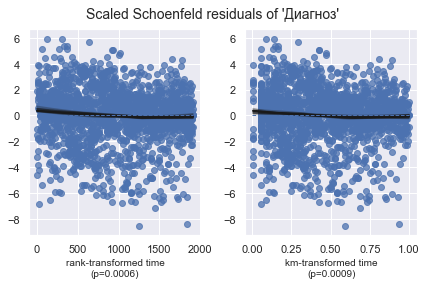

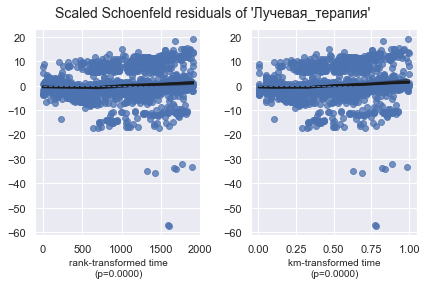

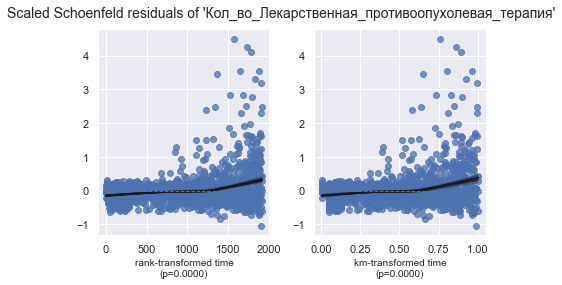

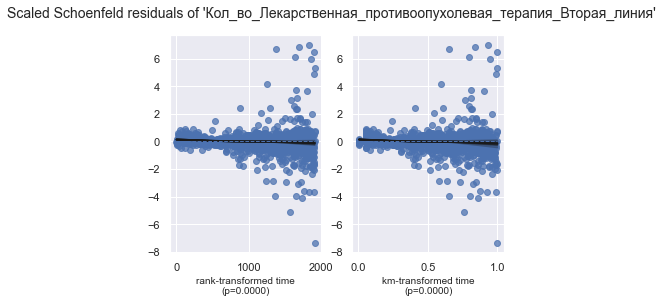

In [23]:
from lifelines import CoxPHFitter

new_features = [f for f in features if f not in bad_features]
df_tr_gb = X_tr_gb[new_features].copy()
df_tr_gb[cnt.TIME_NAME] = y_tr[cnt.TIME_NAME]
df_tr_gb[cnt.CENS_NAME] = y_tr[cnt.CENS_NAME]

cph = CoxPHFitter().fit(df_tr_gb, 'time', 'cens')

axes = cph.check_assumptions(df_tr_gb, show_plots=True)

In [ ]:
from sklearn.model_selection import ParameterGrid

short = False
# BOOST_param_grid = {
#     "size_sample": [0.9],  # [0.5, 0.7],
#     "n_estimators": [30],  # old [30]
#     "ens_metric_name": ["ibs"] if short else ["bic", "ibs"],  # ["roc", "ibs"],  # ["conc", "ibs"]
#     "depth": [10] if short else [15],  # new [5]
#     "criterion": ["confident", "logrank"] if short else ["confident", "weights", "peto",
#                                                          "tarone-ware", "wilcoxon", "logrank"],
#     "min_samples_leaf": [5] if short else [5],  # [20, 100]
#     "max_features": [0.4] if short else [0.7, 0.9],  # [0.2, 0.5],
#     "aggreg_func": ['wei'] if short else ['wei'],
#     "leaf_model": ["base_fast"] if short else ["base_fast"],
#     "all_weight": [True, False],
#     "balance": [None, "balance", "only_log_rank"],
#     "with_arc": [True, False],
#     "n_jobs": [1]
# }

CRAID_param_grid = {
    "depth": [10],
    "balance": [None, "balance", "balance+correct", "only_log_rank"],  # "balance+weights",
    "criterion": ["peto"] if short else ["confident", "peto", "tarone-ware", "wilcoxon", "logrank"],
    "min_samples_leaf": [10] if short else [5, 50],
    'cut': [False, True],
    "woe": [True],  # if short else [True, False],
    "signif": [0.05] if short else [0.05, 1.0],
    "max_features": [1.0],
    "n_jobs": [40]
}

grid_params = ParameterGrid(CRAID_param_grid)
p_size = len(grid_params)
for i_p, p in enumerate(grid_params):
    print(i_p, "="*10, p)

In [ ]:
proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': True, 'categ': categ, # ['Диагноз'], 
                   'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.5, 'min_samples_leaf': 5, 
                   'n_estimators': 100, 'n_jobs': 2, 'size_sample': 0.7}

start_time = time.time()
proboost = IBSBoostingCRAID(**proboost_params)
proboost.fit(X_tr, y_tr)

print(time.time() - start_time)

In [ ]:
# proboost.models[0].visualize()

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
axes[0].scatter(np.arange(proboost.weights.shape[0]), 
                proboost.weights,
                c = np.where(proboost.y_train["cens"], "orange", "blue"))
axes[1].hist(proboost.weights, orientation="horizontal")
plt.show()

In [ ]:
y_tr_cens_counts = np.bincount(y_tr["cens"])
y_bad_cens_counts = np.bincount(y_tr[proboost.weights > 0.9]["cens"])

plt.hist(y_tr["time"], label=f"{y_tr_cens_counts}")
plt.hist(y_tr[proboost.weights > 0.9]["time"], label=f"{y_bad_cens_counts}")
plt.legend()

In [ ]:
# for w in proboost.l_weights[:10]:
#     plt.figure(figsize=(14, 7))
#     plt.scatter(range(w.shape[0]), w, alpha=0.5)
#     plt.show()

In [ ]:
# # pred_bettas = proboost.bettas.copy()
# proboost.bettas = pred_bettas.copy()
# proboost.bettas = proboost.bettas - np.linspace(0, 3000, len(proboost.bettas))

In [ ]:
inv_wei = -1/np.array(proboost.bettas)
plt.plot(inv_wei/sum(inv_wei))

In [ ]:
tr_pred_surv_proboost = proboost.predict_at_times(X_tr, bins=bins, mode="surv")

pred_surv_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="surv")
pred_time_proboost = proboost.predict(X_HO, target=cnt.TIME_NAME)
pred_haz_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="hazard")

In [ ]:
print("TRAIN GB:", metr.ibs(y_tr, y_tr, tr_pred_surv_gbsa, bins, axis=-1))
print("TRAIN PR:", metr.ibs(y_tr, y_tr, tr_pred_surv_proboost, bins, axis=-1))

print("TEST GB:", metr.ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=-1))
print("TEST PR:", metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=-1))

ibs_gbsa_obs = metr.ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=0)
ibs_proboost_obs = metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=0)

In [ ]:
def plot_all_ibs(survival_train, survival_test, preds, bins, axis=1):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    for p in preds:
        ibs_val = metr.ibs(survival_train, survival_test, p, bins, -1)
        axes[0].plot(metr.ibs(survival_train, survival_test, p, bins, axis), label=ibs_val)
    axes[0].legend()
    axes[0].set_title("ALL OBSERVATIONS")
    
    for p in preds:
        ibs_val = metr.ibs(survival_train, survival_test[survival_test["cens"]], 
                           p[survival_test["cens"]], bins, -1)
        axes[1].plot(metr.ibs(survival_train, survival_test[survival_test["cens"]], 
                              p[survival_test["cens"]], bins, axis), label=ibs_val)
    axes[1].legend()
    axes[1].set_title("EVENTS")
    
    for p in preds:
        ibs_val = metr.ibs(survival_train, survival_test[~survival_test["cens"]], 
                           p[~survival_test["cens"]], bins, -1)
        axes[2].plot(metr.ibs(survival_train, survival_test[~survival_test["cens"]], 
                              p[~survival_test["cens"]], bins, axis), label=ibs_val)
    axes[2].legend()
    axes[2].set_title("CENS")
    plt.show()
    
# plt.plot(metr.ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=1))
# plt.plot(metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=1))

# plt.plot(metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_gbsa[~y_HO["cens"]], bins, axis=1))
# plt.plot(metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_proboost[~y_HO["cens"]], bins, axis=1))

# plt.plot(metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_gbsa[y_HO["cens"]], bins, axis=1))
# plt.plot(metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_proboost[y_HO["cens"]], bins, axis=1))

plot_all_ibs(y_tr, y_HO, [pred_surv_gbsa, pred_surv_proboost], bins, axis=1)

In [ ]:
print("EVENT TRAIN GB:", metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred_surv_gbsa[y_tr["cens"]], bins, axis=-1))
print("CENS TRAIN GB:", metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred_surv_gbsa[~y_tr["cens"]], bins, axis=-1))
print()
print("EVENT TRAIN PR:", metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred_surv_proboost[y_tr["cens"]], bins, axis=-1))
print("CENS TRAIN PR:", metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred_surv_proboost[~y_tr["cens"]], bins, axis=-1))
print()
print("EVENT TEST GB:", metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_gbsa[y_HO["cens"]], bins, axis=-1))
print("CENS TEST GB:", metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_gbsa[~y_HO["cens"]], bins, axis=-1))
print()
print("EVENT TEST PR:", metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_proboost[y_HO["cens"]], bins, axis=-1))
print("CENS TEST PR:", metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_proboost[~y_HO["cens"]], bins, axis=-1))

In [ ]:
def mean_harm(x, y):
    return (x+y)#2/(1/x + 1/y)

In [ ]:
print("TRAIN GB:", mean_harm(metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred_surv_gbsa[y_tr["cens"]], bins, axis=-1), 
                             metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred_surv_gbsa[~y_tr["cens"]], bins, axis=-1)))

print("TRAIN PR:", mean_harm(metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred_surv_proboost[y_tr["cens"]], bins, axis=-1), 
      metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred_surv_proboost[~y_tr["cens"]], bins, axis=-1)))

print("TEST GB:", mean_harm(metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_gbsa[y_HO["cens"]], bins, axis=-1), 
      metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_gbsa[~y_HO["cens"]], bins, axis=-1)))

print("TEST PR:", mean_harm(metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_proboost[y_HO["cens"]], bins, axis=-1), 
                  metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_proboost[~y_HO["cens"]], bins, axis=-1)))

In [2408]:
def balance_ibs(survival_train, survival_test, *args, **kwargs):
    survival_test = survival_test.copy()
    survival_test["cens"] = 1
    ibs_event = metr.ibs(survival_train, survival_test, *args, **kwargs)
    survival_test["cens"] = 0
    ibs_cens = metr.ibs(survival_train, survival_test, *args, **kwargs)
    print(ibs_event, ibs_cens)
    return (ibs_event + ibs_cens)/2

In [2409]:
print("TRAIN GB:", balance_ibs(y_tr, y_tr.copy(), tr_pred_surv_gbsa, bins, axis=-1))
print("TRAIN PR:", balance_ibs(y_tr, y_tr.copy(), tr_pred_surv_proboost, bins, axis=-1))

print("TEST GB:", balance_ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=-1))
print("TEST PR:", balance_ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=-1))

0.270288916009449 0.06171882053514758
TRAIN GB: 0.1660038682722983
0.3596971816193217 0.07725590824109613
TRAIN PR: 0.2184765449302089
0.29725846031546777 0.0780350727928604
TEST GB: 0.18764676655416407
0.38435808846460345 0.08559301712802699
TEST PR: 0.2349755527963152


(-1.0, 6.0)

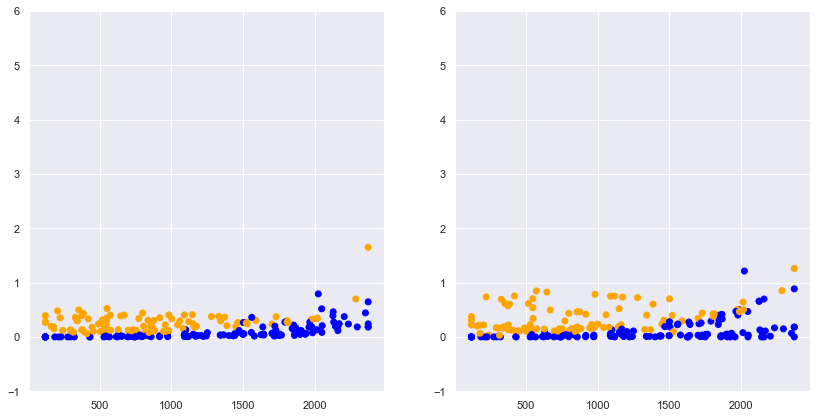

In [2410]:
fig, axes = plt.subplots(figsize=(14, 7), ncols=2)
axes[0].scatter(y_HO["time"], ibs_gbsa_obs, 
            c=np.where(y_HO["cens"], "orange", "blue"))

axes[1].scatter(y_HO["time"], ibs_proboost_obs, 
            c=np.where(y_HO["cens"], "orange", "blue"))

axes[0].set_ylim([-1, 6])
axes[1].set_ylim([-1, 6])

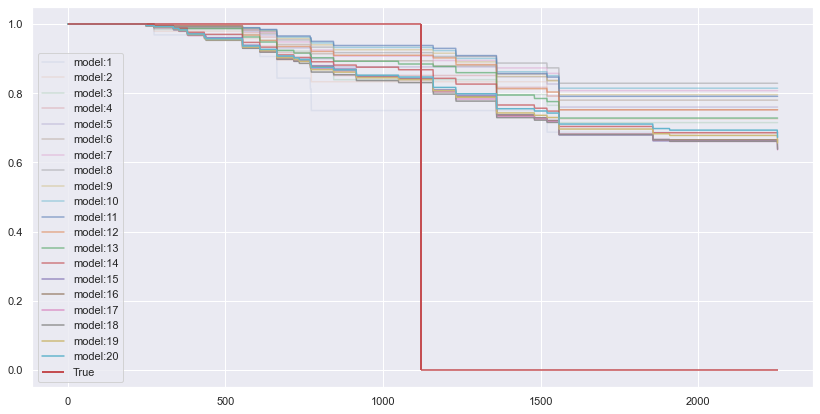

In [1655]:
glob_numb = 25

fig, ax = plt.subplots(figsize=(14, 7))
shared_pred = proboost.models[0].predict_at_times(X_HO, bins=bins, mode="surv")
for i in range(1, 21):
    pred = proboost.models[i].predict_at_times(X_HO, bins=bins, mode="surv")
    shared_pred += pred
#     ax.plot(pred[glob_numb], label = f"model:{i}")
    ax.plot(shared_pred[glob_numb]/(i+1), label = f"model:{i}", alpha=((i+1)/21))

ax.hlines(1.0, 0, y_HO[glob_numb]["time"], color = 'r')
ax.hlines(0.0, y_HO[glob_numb]["time"], len(shared_pred[glob_numb]), color = 'r')
ax.vlines(y_HO[glob_numb]["time"], 0, 1, 
              color = 'r', 
              linestyles = ('solid' if y_HO[glob_numb]["cens"] else 'dashed'),
              linewidth = 2, 
              label = "True")

ax.legend()
plt.show()

In [1656]:
import matplotlib.pyplot as plt

def print_true_pred(y_true, y_preds, labels):
    fig, ax = plt.subplots()
    
    for y_pred, label in zip(y_preds, labels):
        ax.plot(y_pred, label = label)
    ax.hlines(1.0, 0, y_true["time"], color = 'r')
    ax.hlines(0.0, y_true["time"], len(y_preds[0]), color = 'r')
    ax.vlines(y_true["time"], 0, 1, 
                  color = 'r', 
                  linestyles = ('solid' if y_true["cens"] else 'dashed'),
                  linewidth = 2, 
                  label = "True")
    ax.legend()
    plt.show()

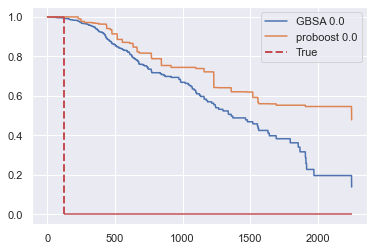

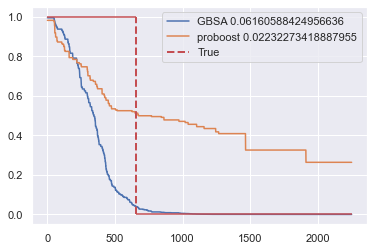

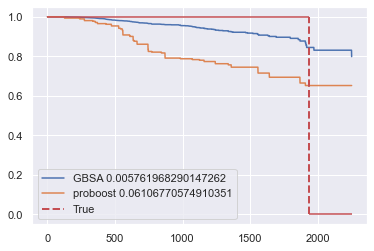

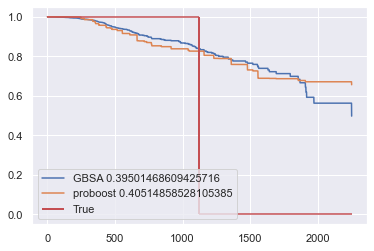

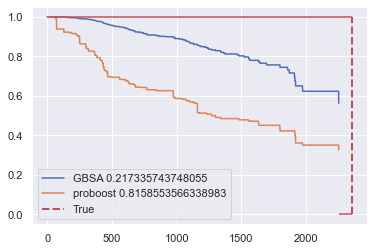

IndexError: index 262 is out of bounds for axis 0 with size 227

In [1657]:
for i in [0, 1, 10, 25, 100, 262]:
    print_true_pred(y_HO[i], 
                    [pred_surv_gbsa[i], 
                     pred_surv_proboost[i]],
                    [f"GBSA {ibs_gbsa_obs[i]}", 
                     f"proboost {ibs_proboost_obs[i]}"])

#### Выводы

1. ibs ниже для 'all_weight': True (до 0.125+)
2. Веса моделей без зависимостей
3. Веса наблюдений почти одинаковы
4. При искусственной регуляризации на поздние деревья прогноз не меняется.
5. Не может обучиться на тренировочной (на самих событиях)
6. BEST PROBOOST: 

   {'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
    'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'ibs', 
    'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 10, 
    'n_estimators': 200, 'n_jobs': 2, 'size_sample': 0.7}

TRAIN GB: 0.040758365855872156

TRAIN PR: 0.07876184911209028

TEST GB: 0.11512669052794938

TEST PR: 0.12589051411686047

6. Самые важные по gbsa (>0.05): ['Вес', 'Рост', 'Возраст', 'Индекс_массы', 'Диагноз',
    'Кол_во_Лекарственная_противоопухолевая_терапия',
    'Кол_во_Лекарственная_противоопухолевая_терапия_Первая_линия']

In [480]:
# gbsa.feature_importances_[np.argsort(gbsa.feature_importances_)[::-1]]
X_tr.columns[gbsa.feature_importances_ > 0.05]

Index(['Вес', 'Рост', 'Возраст', 'Индекс_массы', 'Диагноз',
       'Кол_во_Лекарственная_противоопухолевая_терапия',
       'Кол_во_Лекарственная_противоопухолевая_терапия_Первая_линия'],
      dtype='object')

### Best hyperparameters

In [ ]:
# ProbBoostingCRAID PARAMETERS (ONK)

proboost_params = {'balance': "balance", 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
                   'criterion': 'confidence', 'depth': 20, 'ens_metric_name': 'conc', 
                   'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 20, 
                   'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7}

# TEST PR: 0.1221077

In [ ]:
# ProbBoostingCRAID PARAMETERS (INVERT ONK)

proboost_params = {'balance': "only_log_rank", 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
                   'criterion': 'confidence', 'depth': 20, 'ens_metric_name': 'conc', 
                   'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 5, 
                   'n_estimators': 200, 'n_jobs': 2, 'size_sample': 0.7}

# INVERT TEST PR: 0.0450258

proboost_params = {'balance': "only_log_rank", 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
                   'criterion': 'confidence', 'depth': 30, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.9, 'min_samples_leaf': 5, 
                   'n_estimators': 200, 'n_jobs': 2, 'size_sample': 0.9}

# INVERT TEST PR: 0.04492703506292507

proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
                   'criterion': 'wilcoxon', 'depth': 30, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.9, 'min_samples_leaf': 5, 
                   'n_estimators': 200, 'n_jobs': 2, 'size_sample': 0.9}

# # TEST PR: 0.04439044992620185

In [ ]:
# IBSBOOST PARAMETERS (ONK)

proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
                   'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'conc', 
                   'leaf_model': 'wei_survive', 'max_features': 0.7, 'min_samples_leaf': 10, 
                   'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7}

# TEST PR: 0.11094938889349701

In [ ]:
# IBSPROBOOST PARAMETERS (GBSG)

proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': False, 'categ': categ, #['Диагноз'], 
                   'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'conc', 
                   'leaf_model': 'base_fast', 'max_features': "sqrt", 'min_samples_leaf': 5, 
                   'n_estimators': 50, 'n_jobs': 2, 'size_sample': 0.7}
 
# TEST PR: 0.16469216780427154


# IBSPROBOOST PARAMETERS (ONK)
proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
                   'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'wei_survive', 'max_features': 0.7, 'min_samples_leaf': 5, 
                   'n_estimators': 50, 'n_jobs': 2, 'size_sample': 0.7}

# TEST PR: 0.12181156729133115

### Visualizations only for PROBOOST

In [9]:
def loglikelihood_i(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10) ** cens
    return np.log(sf_by_times) + np.log(hf_by_times)


def values_to_hist(values):
    unq, idx = np.unique(values, return_inverse=True)
    # calculate the weighted frequencies of these indices
    freqs_idx = np.bincount(idx)
    # reconstruct the array of frequencies of the elements
    return freqs_idx[idx]


class VisProbBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "ProbBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        pred_hf = model.predict_at_times(X_sub, bins=self.bins, mode="hazard")

        time_hist = values_to_hist(y_sub["time"])
        lp_ti = np.log(time_hist / y_sub["time"].shape)
        lp_xi_ti = np.log(1 / time_hist)
        likel = loglikelihood_i(y_sub["time"], y_sub["cens"], pred_sf, pred_hf, self.bins)

        lp_xi = lp_ti + lp_xi_ti - likel
        wei = - np.exp(-lp_xi)
        betta = np.sum(likel)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] + wei_i)
#         self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())
        self.weights = (self.weights - self.weights.min())
        self.weights /= np.sum(self.weights)
        
        fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
        axes[0].scatter(np.arange(self.weights.shape[0]), 
                        self.weights,
                        c = np.where(self.y_train["cens"], "orange", "blue"))
        axes[1].hist(self.weights, orientation="horizontal")
        plt.show()

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = -1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)
    
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)
        
        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y
        
        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_weights = []
        self.update_params()
        
        for i in range(self.n_estimators):
            prob_weights = self.weights  # arc_x4(self.weights)
            x_sub = self.X_train.sample(n=self.size_sample, weights=prob_weights,  # self.weights
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = prob_weights[x_sub['ind_start']]  # self.weights

            model = CRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)
            
            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
            
            # print(betta_i)
            self.ens_metr[i] = self.score_oob()
            
            if not (self.tolerance) and i > 0:
                print(f"METRIC: {self.ens_metr[i-1]} -> +1 model METRIC: {self.ens_metr[i]}")
                if self.descend_metr:
                    stop = self.ens_metr[i-1] < self.ens_metr[i]
                else:
                    stop = self.ens_metr[i-1] > self.ens_metr[i]
                if stop:
                    self.select_model(0, len(self.models)-1)
                    break
        
        if self.tolerance:
            self.tolerance_find_best()
        print('fitted:', len(self.models), 'models.')

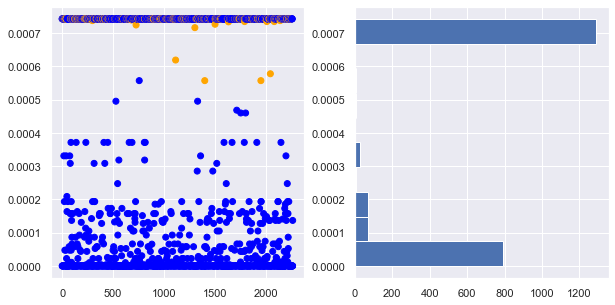

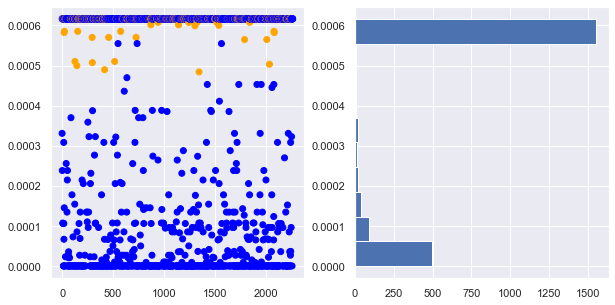

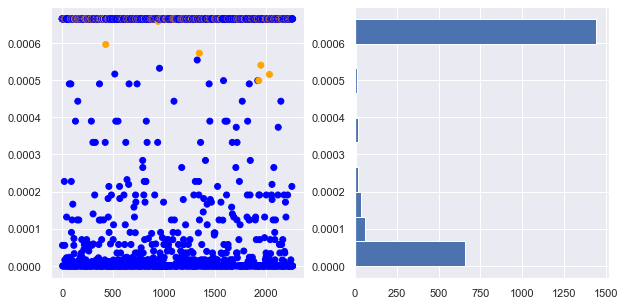

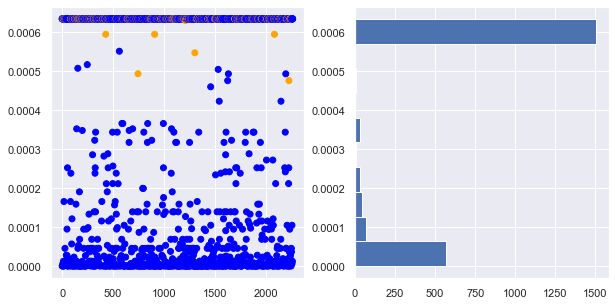

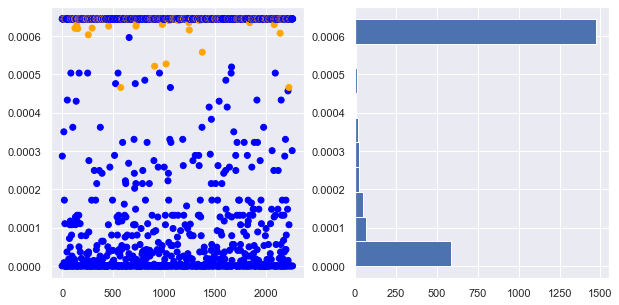

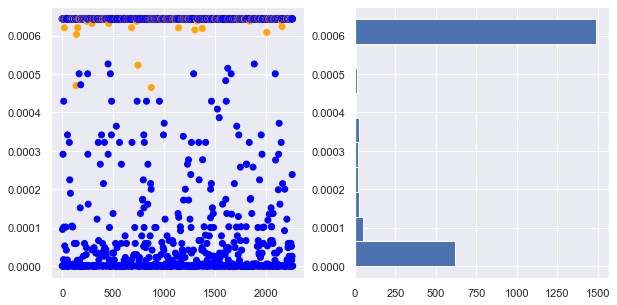

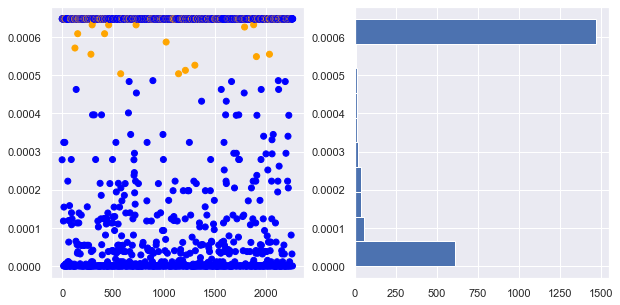

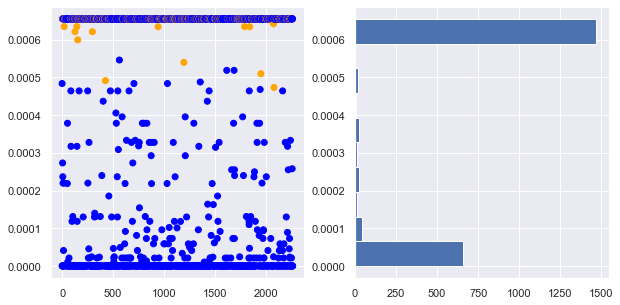

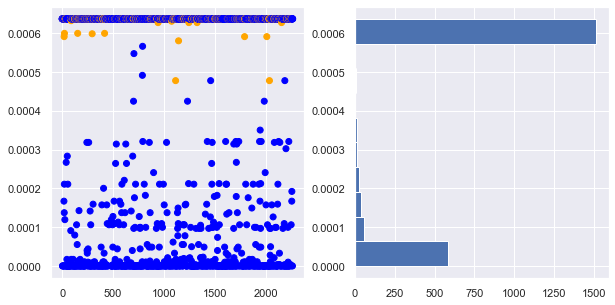

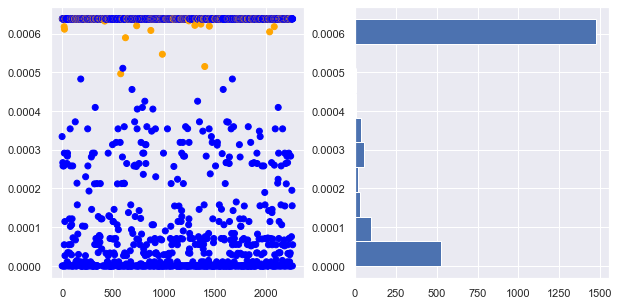

[0.2353 0.1782 0.1705 0.17   0.1646 0.16   0.1571 0.1528 0.1511 0.1486]
fitted: 10 models.


In [10]:
vproboost_params = {'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
                   'criterion': 'weights', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 1, 
                   'n_estimators': 10, 'n_jobs': 2, 'size_sample': 0.7}

vproboost = VisProbBoostingCRAID(**vproboost_params)
vproboost.fit(X_tr, y_tr)

In [11]:
vproboost_params = {'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
                   'criterion': 'weights', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 10, 
                   'n_estimators': 100, 'n_jobs': 2, 'size_sample': 0.7}

vproboost = BoostingCRAID(**vproboost_params)
vproboost.fit(X_tr, y_tr)

[0.2144 0.1889 0.1822 0.1747 0.165  0.1635 0.1577 0.1539 0.1541 0.1545
 0.1533 0.1512 0.1484 0.1482 0.147  0.1484 0.1477 0.1462 0.1456 0.146
 0.1472 0.1468 0.146  0.1456 0.1457 0.1455 0.1449 0.1451 0.1449 0.1447
 0.1451 0.1447 0.1442 0.144  0.1435 0.1438 0.1435 0.1442 0.1442 0.1442
 0.1443 0.1445 0.1444 0.1443 0.1443 0.1445 0.1446 0.1448 0.1445 0.1448
 0.1453 0.1455 0.1455 0.1452 0.1449 0.1451 0.1453 0.1457 0.1458 0.146
 0.1457 0.1456 0.1454 0.1457 0.1454 0.1455 0.1457 0.1455 0.1455 0.1456
 0.1453 0.1452 0.1453 0.1452 0.1451 0.1448 0.1448 0.1448 0.1447 0.145
 0.1447 0.1447 0.1445 0.1444 0.1443 0.1444 0.1445 0.1445 0.1444 0.1444
 0.1443 0.1443 0.1442 0.1441 0.1443 0.1443 0.1444 0.1444 0.1441 0.1441]
fitted: 35 models.


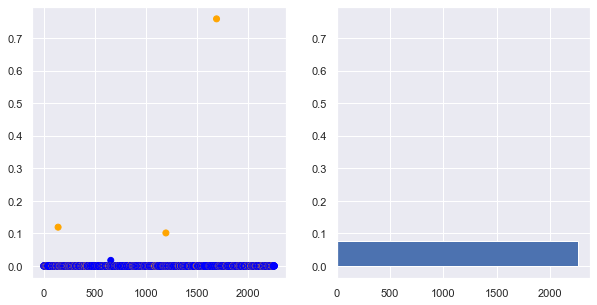

In [12]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
axes[0].scatter(np.arange(vproboost.weights.shape[0]), 
                vproboost.weights,
                c = np.where(vproboost.y_train["cens"], "orange", "blue"))
axes[1].hist(vproboost.weights, orientation="horizontal")
plt.show()

In [13]:
tr_pred_surv_boost = vproboost.predict_at_times(X_tr, bins=bins, mode="surv")
print("TRAIN emp GB:", metr.ibs(y_tr, y_tr, tr_pred_surv_boost, bins, axis=-1))

pred_surv_boost = vproboost.predict_at_times(X_HO, bins=bins, mode="surv")
print("TEST emp GB:", metr.ibs(y_tr, y_HO, pred_surv_boost, bins, axis=-1))


TRAIN emp GB: 0.09731145260444893
TEST emp GB: 0.14330786637613338


### Oversampling from imbalance

In [112]:
from imblearn.over_sampling import RandomOverSampler

In [115]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y["cens"])

In [120]:
np.bincount(y["cens"])

array([2856,  524], dtype=int64)

In [124]:
from imblearn.over_sampling import RandomOverSampler

def get_oversample(df, target=cnt.CENS_NAME):
    oversample = RandomOverSampler(sampling_strategy='minority')
    df_over, _ = oversample.fit_resample(df, df[target])
    return df_over

X_full = X.copy()
X_full[cnt.CENS_NAME] = y[cnt.CENS_NAME]
X_full[cnt.TIME_NAME] = y[cnt.TIME_NAME]

get_oversample(X_full, target=cnt.CENS_NAME)[cnt.CENS_NAME].value_counts()

False    2856
True     2856
Name: cens, dtype: int64

### SMOTE from imbalance

1. [Example](https://github.com/KhyatiMahendru/Balancing-data-SMOTE/blob/master/CreditCardFraudDetection.ipynb)
2. [Documentation](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC)
3. [Survival Analysis + SMOTE Usage (Improving the Prediction of Heart Failure Patients’ Survival Using SMOTE and Effective Data Mining Techniques)](https://github.com/deveshpatel0101/heart-failure-patients-survival/blob/master/notebooks/decision_tree_with_smote.ipynb)

In [128]:
def get_n(n):
    yield from range(n)
    
next(get_n(4))

0

In [96]:
categ

['Диагноз']

In [97]:
from imblearn.over_sampling import SMOTE

In [98]:
X_tr_1[categ].value_counts()

Диагноз
2          1503
1          1176
0          1147
dtype: int64

In [110]:
sm = SMOTE(random_state=42)

X_tr_smote = X_tr.copy()
X_tr_smote[cnt.TIME_NAME] = y_tr[cnt.TIME_NAME]
X_tr_1, y_tr_1 = sm.fit_resample(X_tr_smote.fillna(0).replace(np.nan, 0), y_tr[cnt.CENS_NAME])

y_tr_1 = cnt.get_y(y_tr_1, X_tr_1[cnt.TIME_NAME])
X_tr_1 = X_tr_1.drop(cnt.TIME_NAME, axis=1)

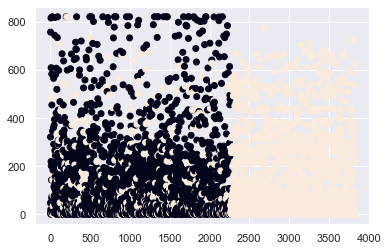

In [111]:
plt.scatter(np.arange(y_tr_1.shape[0]), 
            y_tr_1["time"], c = y_tr_1["cens"])

In [95]:
np.bincount(y_tr["cens"]), np.bincount(y_tr_1["cens"])

(array([1913,  351], dtype=int64), array([1913, 1913], dtype=int64))